In [58]:
from helpers import *
from Line import *
import pprint
pp = pprint.PrettyPrinter(indent=4)

TESTIMG = 'test_images/solidWhiteRight.jpg'
img = readImg(TESTIMG)
params = getParams()



%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# %load lanedetector.py
from helpers import *

blkrSize = params["blurKernalSize"]
cht = params["cannyHT"]
clt = params["cannyLT"]
stage = params["outputStage"]


hsv = getHSV(img)

bMask = hsv[:,:,2] > params.get("bThresh", 200)

if params["useBrightness"]:
    # gray = hsv[:,:,2]
    gray = bMask.astype(np.uint8)*255
else:
    gray = grayscale(img)

blur = gaussian_blur(gray, kernel_size=blkrSize)

ht = cht
lt = clt
canny_edges = canny(blur, low_threshold=lt, high_threshold=ht)

#hsv = getHSV(img)
bMask = cv2.bitwise_and(img, img, mask=bMask.astype(np.uint8))
bMask = cv2.cvtColor(bMask, cv2.COLOR_BGR2RGB)


rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = params.get("hThresh", 10)
min_line_length = params.get("hMinLineLen", 20)
max_line_gap = params.get("hMaxLineGap", 1)



hLines = get_hough_lines(canny_edges, rho, theta, threshold, min_line_length, max_line_gap)
houghImg = draw_hough_lines(canny_edges, hLines)

linedImg = np.copy(img)

lnValsLeft = []
lnValsRight = []

for l in hLines:
    ln = LineFromCVLine(l)
    if(ln.isValidLaneCandidate(params)):
        #if ln.distFromPoint(450,540) < 400:
        #if 540 - max(ln.y1, ln.y2) < 200:
            #ln.draw(linedImg)
            #print(ln.distFromPoint(450,540), ln.slope)
            
        lnVal = (540 - max(ln.y1, ln.y2) , ln.length(), ln.slope, ln)
        if(ln.slope < 0):
            lnValsLeft.append(lnVal)
        else:
            lnValsRight.append(lnVal)

lnValsLeft.sort(key=lambda x: x[0] + 1000/x[1])
lnValsRight.sort(key=lambda x: x[0] + 1000/x[1])
#pp.pprint(lnValsLeft)
#pp.pprint(lnValsRight)

lnValsLeft[0][3].draw(linedImg)
lnValsRight[0][3].draw(linedImg)

lnValsLeft[0][3].extrapolateTillBase(linedImg)
lnValsRight[0][3].extrapolateTillBase(linedImg)

outpDict = {
        "final": linedImg,
        "blur": blur,
        "gray": gray,
        "canny": canny_edges,
        "hsv": hsv,
        "brightness": hsv[:,:,2],
        "hue": hsv[:,:,1],
        "saturation": hsv[:,:,0],
        "bMask": bMask,
        "hough": houghImg,

}

outImg = outpDict[stage]


TypeError: extrapolateTillBase() takes at least 3 arguments (2 given)

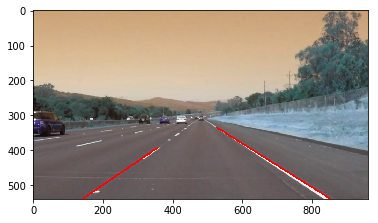

In [60]:
showimg(outImg)

In [54]:
l = LineFromCVLine(hLines[0])

In [10]:
outImg.shape

(540, 960, 3)

In [6]:
params

{u'bThresh': 213,
 u'blurKernalSize': 5,
 u'cannyHT': 300,
 u'cannyLT': 40,
 u'hMaxLineGap': 17.6,
 u'hMinLineLen': 9,
 u'hThresh': 11,
 u'images': u'all',
 u'outputStage': u'final',
 u'useBrightness': True}